In [2]:
# Warehous Inventory Optimization : Avoiding overstocking problem by demannd forecasting  and 
# setting inventory levels based on predicted demand and safety stock

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

In [4]:
# 1. Load the datasets
train = pd.read_csv('train.csv', parse_dates=['Date'], low_memory=False)
store = pd.read_csv('store.csv')
data = train.merge(store, on='Store', how='left')

In [5]:
# 2. Preprocess the data
# Handle missing values in store data
data['CompetitionDistance'] = data['CompetitionDistance'].fillna(data['CompetitionDistance'].median())
data['CompetitionOpenSinceMonth'] = data['CompetitionOpenSinceMonth'].fillna(0)
data['CompetitionOpenSinceYear'] = data['CompetitionOpenSinceYear'].fillna(0)
data['Promo2SinceWeek'] = data['Promo2SinceWeek'].fillna(0)
data['Promo2SinceYear'] = data['Promo2SinceYear'].fillna(0)
data['PromoInterval'] = data['PromoInterval'].fillna('')

# Filter out closed stores and invalid sales
data = data[data['Open'] == 1]
data = data[data['Sales'] > 0]

# Aggregate by week (total sales across all stores)
weekly_sales = data.groupby(pd.Grouper(key='Date', freq='W'))['Sales'].sum().reset_index()
weekly_sales.columns = ['ds', 'y']  # 'ds' = date, 'y' = sales
weekly_sales['ds'] = pd.to_datetime(weekly_sales['ds'])

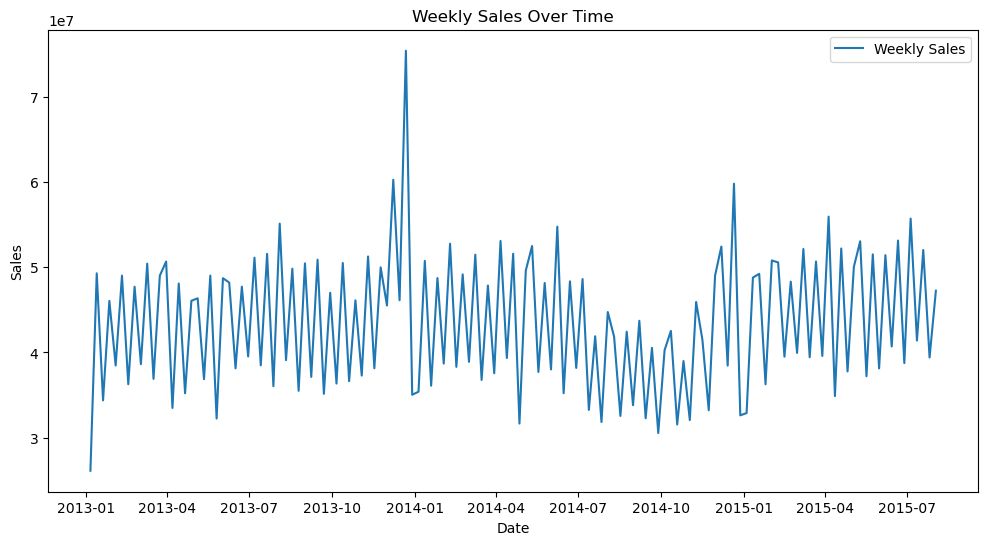

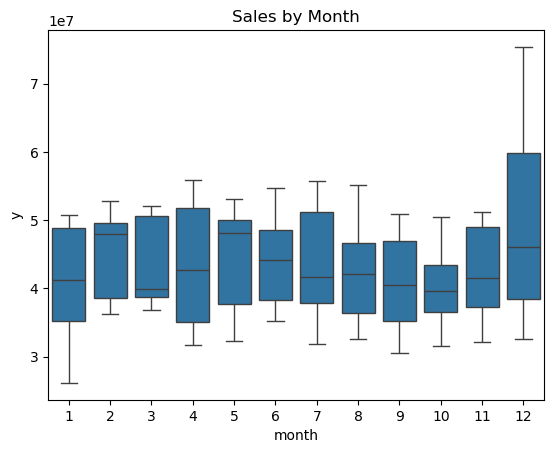

In [6]:
# 3. Exploratory Data Analysis (EDA)
# Plot weekly sales
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales['ds'], weekly_sales['y'], label='Weekly Sales')
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Check for seasonality (monthly patterns)
weekly_sales['month'] = weekly_sales['ds'].dt.month
sns.boxplot(x='month', y='y', data=weekly_sales)
plt.title('Sales by Month')
plt.show()

C:\Users\MaheshMadai\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


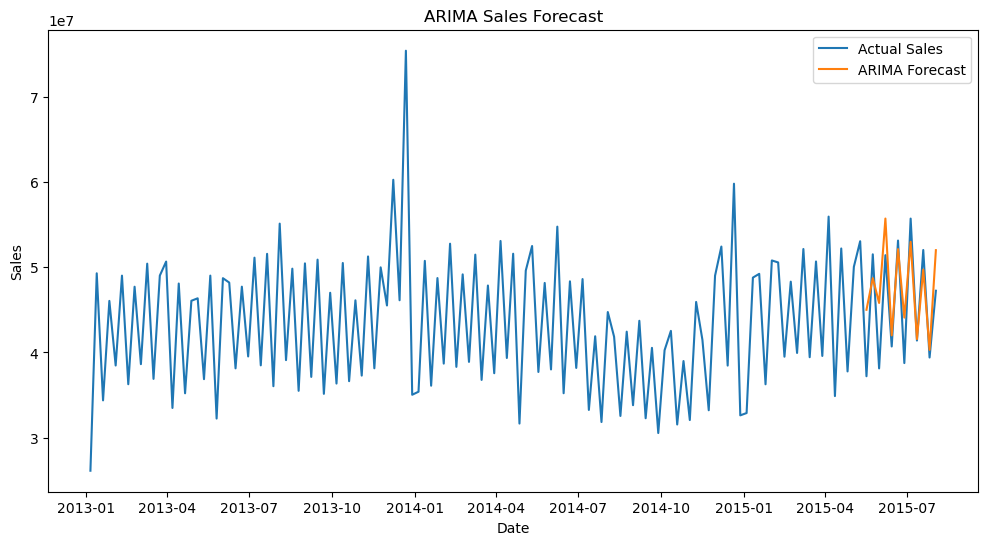

In [7]:
# 4. Demand Forecasting with ARIMA
# Prepare data for ARIMA
arima_data = weekly_sales.set_index('ds')['y']
arima_data.index = arima_data.index.to_period('W-SUN').to_timestamp('W-SUN')  # Explicitly set frequency

# Split data into train and test
train_arima = arima_data.iloc[:-12]
test_arima = arima_data.iloc[-12:]

# Fit ARIMA model
model_arima = ARIMA(train_arima, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52)).fit()

# Forecast for 12 weeks
arima_forecast = model_arima.forecast(steps=12)

# Create a dataframe for the forecast
forecast_dates = pd.date_range(start=weekly_sales['ds'].iloc[-12], periods=12, freq='W-SUN')
arima_forecast_df = pd.DataFrame({
    'ds': forecast_dates,
    'yhat': arima_forecast
})

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales['ds'], weekly_sales['y'], label='Actual Sales')
plt.plot(arima_forecast_df['ds'], arima_forecast_df['yhat'], label='ARIMA Forecast')
plt.title('ARIMA Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [8]:
# 5. Evaluation of ARIMA
mae_arima = mean_absolute_error(test_arima, arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(test_arima, arima_forecast))
mape_arima = np.mean(np.abs((test_arima - arima_forecast) / test_arima)) * 100
print(f'ARIMA MAE: {mae_arima:.2f}')
print(f'ARIMA RMSE: {rmse_arima:.2f}')
print(f'ARIMA MAPE: {mape_arima:.2f}%')

# Aggregate by week (total sales across all stores)
weekly_sales = data.groupby(pd.Grouper(key='Date', freq='W'))['Sales'].sum().reset_index()
weekly_sales.columns = ['ds', 'y']  # 'ds' = date, 'y' = sales
weekly_sales['ds'] = pd.to_datetime(weekly_sales['ds'])
print(print(weekly_sales.head()))

ARIMA MAE: 3418700.73
ARIMA RMSE: 4213784.48
ARIMA MAPE: 7.98%
          ds         y
0 2013-01-06  26129335
1 2013-01-13  49275222
2 2013-01-20  34377765
3 2013-01-27  46040169
4 2013-02-03  38466029
None


In [9]:
# 6. Benchmarking with XGBoost
# Create features (lags, rolling mean, promo, holidays)
weekly_sales['lag_1'] = weekly_sales['y'].shift(1)
weekly_sales['lag_2'] = weekly_sales['y'].shift(2)
weekly_sales['rolling_mean_4'] = weekly_sales['y'].rolling(window=4).mean()

# Aggregate promo and holiday features at weekly level
weekly_promo = data.groupby(pd.Grouper(key='Date', freq='W'))['Promo'].mean().reset_index()
weekly_promo = weekly_promo.rename(columns={'Date': 'ds'})  # Rename to match weekly_sales
weekly_promo['ds'] = pd.to_datetime(weekly_promo['ds'])  # Ensure datetime

weekly_holiday = data.groupby(pd.Grouper(key='Date', freq='W'))['SchoolHoliday'].mean().reset_index()
weekly_holiday = weekly_holiday.rename(columns={'Date': 'ds'})  # Rename to match weekly_sales
weekly_holiday['ds'] = pd.to_datetime(weekly_holiday['ds'])  # Ensure datetime

# Check for duplicates
weekly_promo = weekly_promo.drop_duplicates(subset='ds')
weekly_holiday = weekly_holiday.drop_duplicates(subset='ds')

# Merge with outer join to handle missing dates
weekly_sales = weekly_sales.merge(weekly_promo, on='ds', how='left').merge(weekly_holiday, on='ds', how='left')

# Fill missing values for Promo and SchoolHoliday
# weekly_sales = weekly_sales['Promo'].fillna(0)
# weekly_sales = weekly_sales['SchoolHoliday'].fillna(0)
# weekly_sales = weekly_sales.dropna(subset=['lag_1', 'lag_2', 'rolling_mean_4'])

# Split data into train and test
train_xgb = weekly_sales.iloc[:-12]
test_xgb = weekly_sales.iloc[-12:]

# Features and target
X_train = train_xgb[['lag_1', 'lag_2', 'rolling_mean_4', 'Promo', 'SchoolHoliday']]
y_train = train_xgb['y']
X_test = test_xgb[['lag_1', 'lag_2', 'rolling_mean_4', 'Promo', 'SchoolHoliday']]
y_test = test_xgb['y']

# Train XGBoost
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
model_xgb.fit(X_train, y_train)

# Predict
xgb_forecast = model_xgb.predict(X_test)

# Create a dataframe for XGBoost forecast
xgb_forecast_df = pd.DataFrame({
    'ds': test_xgb['ds'],
    'yhat': xgb_forecast
})

# Evaluate
mae_xgb = mean_absolute_error(y_test, xgb_forecast)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_forecast))
mape_xgb = np.mean(np.abs((y_test - xgb_forecast) / y_test)) * 100
print(f'XGBoost MAE: {mae_xgb:.2f}')
print(f'XGBoost RMSE: {rmse_xgb:.2f}')
print(f'XGBoost MAPE: {mape_xgb:.2f}%')

XGBoost MAE: 2760339.00
XGBoost RMSE: 3419715.56
XGBoost MAPE: 6.14%



Performance Comparison:
     Model           MAE          RMSE      MAPE
0    ARIMA  3.418701e+06  4.213784e+06  7.978214
1  XGBoost  2.760339e+06  3.419716e+06  6.139822


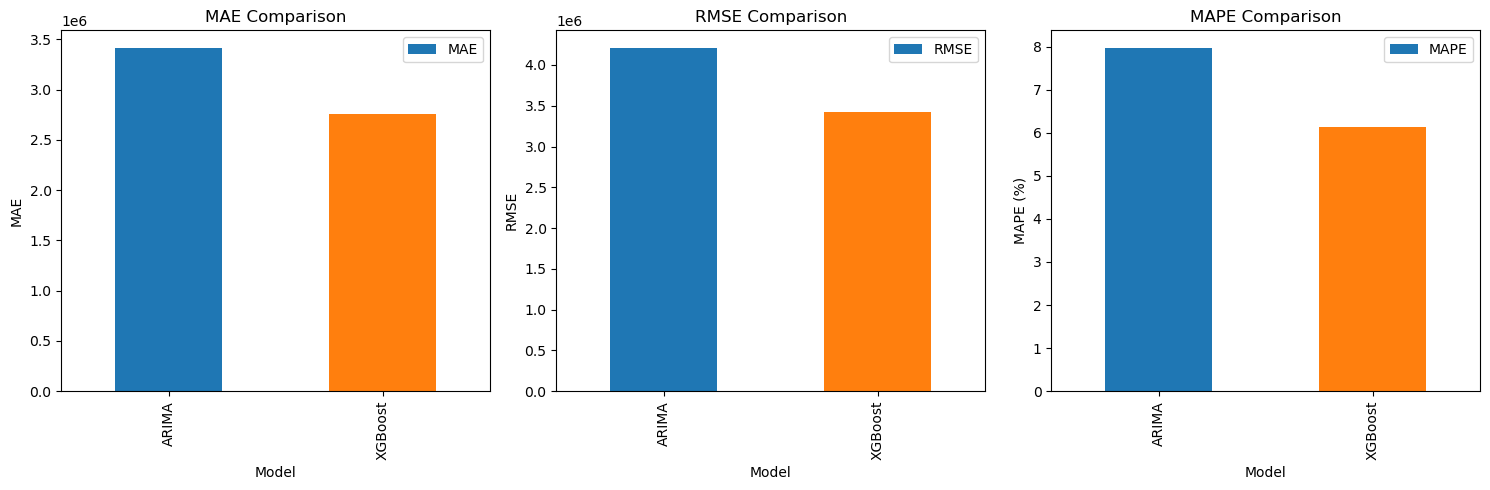

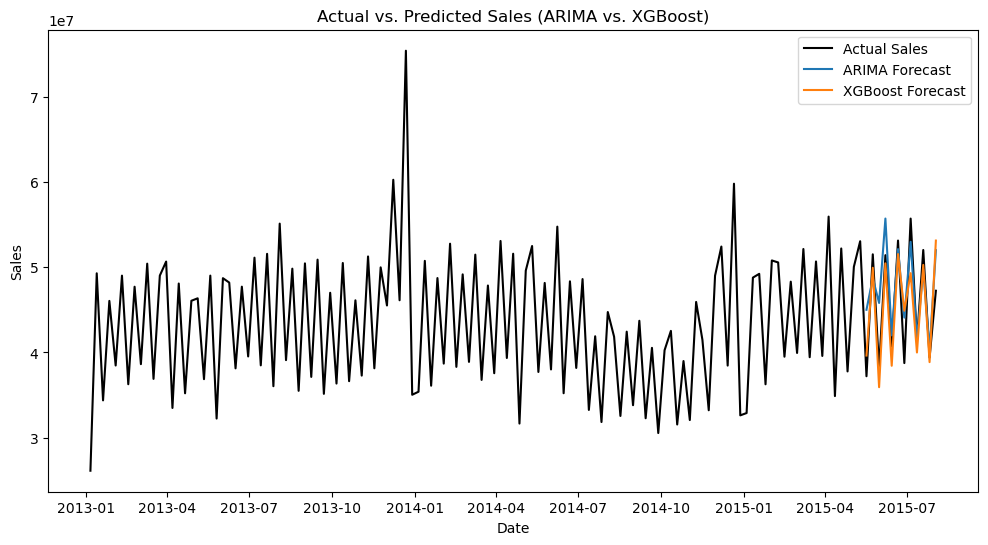

In [10]:
# 7. Compare ARIMA and XGBoost Performance
# Compile metrics
metrics = pd.DataFrame({
    'Model': ['ARIMA', 'XGBoost'],
    'MAE': [mae_arima, mae_xgb],
    'RMSE': [rmse_arima, rmse_xgb],
    'MAPE': [mape_arima, mape_xgb]
})
print("\nPerformance Comparison:")
print(metrics)

# Plot metrics comparison
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
metrics.plot(x='Model', y='MAE', kind='bar', ax=ax[0], color=['#1f77b4', '#ff7f0e'])
ax[0].set_title('MAE Comparison')
ax[0].set_ylabel('MAE')
metrics.plot(x='Model', y='RMSE', kind='bar', ax=ax[1], color=['#1f77b4', '#ff7f0e'])
ax[1].set_title('RMSE Comparison')
ax[1].set_ylabel('RMSE')
metrics.plot(x='Model', y='MAPE', kind='bar', ax=ax[2], color=['#1f77b4', '#ff7f0e'])
ax[2].set_title('MAPE Comparison')
ax[2].set_ylabel('MAPE (%)')
plt.tight_layout()
plt.show()

# Plot actual vs. predicted for both models
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales['ds'], weekly_sales['y'], label='Actual Sales', color='black')
plt.plot(arima_forecast_df['ds'], arima_forecast_df['yhat'], label='ARIMA Forecast', color='#1f77b4')
plt.plot(xgb_forecast_df['ds'], xgb_forecast_df['yhat'], label='XGBoost Forecast', color='#ff7f0e')
plt.title('Actual vs. Predicted Sales (ARIMA vs. XGBoost)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [11]:
# 8. Inventory Optimization (using better model based on MAPE)

average_weekly_demand = 5000000  # Example average from your chart (adjust based on your data)

# Model selection based on MAPE
mape_arima = 7.98
if mape_arima <= mape_xgb:
    print("Using ARIMA forecast for inventory optimization (better MAPE)")
    forecast_for_inventory = arima_forecast

    safety_stock = (average_weekly_demand * (mape_arima / 100) * 1.5) * 2  # 1.5x error over 2 weeks
    print(f"Calculated Safety Stock: {safety_stock:.2f} units")
    
else:
    print("Using XGBoost forecast for inventory optimization (better MAPE)")
    forecast_for_inventory = xgb_forecast
    safety_stock = (average_weekly_demand * (mape_xgb / 100) * 1.5) * 2  # 1.5x error over 2 weeks
    print(f"Calculated Safety Stock: {safety_stock:.2f} units")

lead_time_weeks = 2

reorder_point = forecast_for_inventory[:lead_time_weeks].sum() + safety_stock
print(f'Reorder Point: {reorder_point:.2f} units')

Using XGBoost forecast for inventory optimization (better MAPE)
Calculated Safety Stock: 920973.27 units
Reorder Point: 90479501.27 units


In [12]:
# 9. Save Results
# Save ARIMA forecast
arima_forecast_df.to_csv('arima_sales_forecast.csv', index=False)

# Save XGBoost forecast
xgb_forecast_df.to_csv('xgb_sales_forecast.csv', index=False)


# Save weekly data
weekly_sales.to_csv('weekly_sales.csv', index=False)
